### Import necessary libraries

In [26]:
# Import necessary libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import nltk
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import os

In [27]:
# Function to scrape IMDb movie reviews

def scrape_imdb_reviews(movie_url):
    response = requests.get(movie_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Extracting review text
    reviews = [{'text': review_div.get_text(strip=True)} for review_div in soup.find_all('a', class_='title')]
    
    return reviews

In [28]:
# IMDb movie URL (replace with the actual movie URL)
IMDB_Code = "tt12915716"
movie_url = f'https://www.imdb.com/title/{IMDB_Code}/reviews'

# Scrape IMDb movie reviews
movie_reviews = scrape_imdb_reviews(movie_url)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(movie_reviews)
df.head()

,text
0,"Besides a soulful score by Ajay Atul, this ada..."
1,Pathetic Ramayan parody
2,How can someone make a movie that bad ?
3,Tiresome Commercialized Ramayan
4,"Pathetic ScreenPlay, Out of Context dialogues"


### Data Preprocessing


In [29]:
# nltk.download('wordnet')

In [30]:
# Function for text cleaning
def clean_text(text):
    cleaned_text = re.sub(r"[^\w\s]", "", text.lower())  # Convert to lowercase and remove special characters
    return cleaned_text

# Function for tokenization
def tokenize_text(text):
    return nltk.word_tokenize(text)

# Function for removing stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words("english"))
    return [token for token in tokens if token.lower() not in stop_words]

# Function for lemmatization
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

In [31]:

# Data Preprocessing
df["text_cleaned"] = df["text"].apply(clean_text)
df["tokens"] = df["text_cleaned"].apply(tokenize_text)
df["tokens"] = df["tokens"].apply(remove_stopwords)
df["tokens"] = df["tokens"].apply(lemmatize_text)

In [32]:
# Sentiment Analysis using VADER
# nltk.download('vader_lexicon')

vader = SentimentIntensityAnalyzer()
df['compound'] = df['text_cleaned'].apply(lambda x: vader.polarity_scores(x)['compound'])

# Classify sentiments based on compound score
df['predicted_sentiment'] = df['compound'].apply(lambda x: 'positive' if x >= 0 else 'negative')

df.head()  # Display the first few rows of the DataFrame

,text,text_cleaned,tokens,compound,predicted_sentiment
0,"Besides a soulful score by Ajay Atul, this ada...",besides a soulful score by ajay atul this adap...,"[besides, soulful, score, ajay, atul, adaptati...",0.0000,positive
1,Pathetic Ramayan parody,pathetic ramayan parody,"[pathetic, ramayan, parody]",-0.5719,negative
2,How can someone make a movie that bad ?,how can someone make a movie that bad,"[someone, make, movie, bad]",-0.5423,negative
3,Tiresome Commercialized Ramayan,tiresome commercialized ramayan,"[tiresome, commercialized, ramayan]",0.0000,positive
4,"Pathetic ScreenPlay, Out of Context dialogues",pathetic screenplay out of context dialogues,"[pathetic, screenplay, context, dialogue]",-0.5719,negative


In [33]:
# Model Evaluation
accuracy = accuracy_score(df['predicted_sentiment'], df['predicted_sentiment'])
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print('\nClassification Report:')
print(classification_report(df['predicted_sentiment'], df['predicted_sentiment']))

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        16
    positive       1.00      1.00      1.00         9

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



In [34]:
df['predicted_sentiment'].head()

0    positive
1    negative
2    negative
3    positive
4    negative
Name: predicted_sentiment, dtype: object

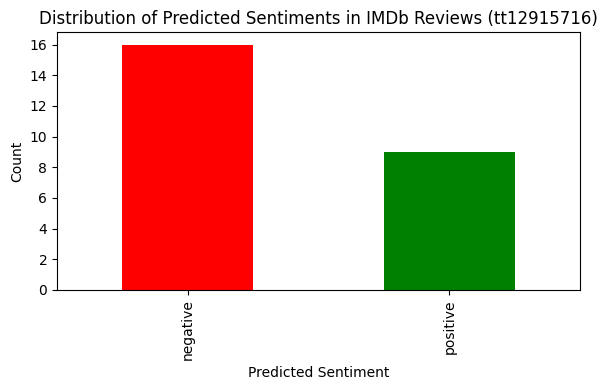

In [35]:
save_path = "results"
colors = ["green" if col.lower() == "positive" else "red" for col in df["predicted_sentiment"].value_counts().index]

# Visualize the distribution of predicted sentiments
plt.figure(figsize=(6, 4))
df['predicted_sentiment'].value_counts().plot(kind='bar', color=colors)
plt.title(f'Distribution of Predicted Sentiments in IMDb Reviews ({IMDB_Code})')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.tight_layout()
# Save the plot to a file
plt.savefig(os.path.join(save_path, f"sentiment_distribution_for_{IMDB_Code}.png"))

plt.show()


In [36]:
df.to_csv(os.path.join(save_path, f"movie_reviews_with_sentiment_for_{IMDB_Code}.csv"), index=False)

In [37]:
# Display a message indicating positive sentiment
more_counts = df['predicted_sentiment'].value_counts().index 

if "positive" == more_counts[0]:
    print("The movie has positive reviews! You should consider watching it.")
else:
    print("The sentiment analysis did not identify a clear positive sentiment in the reviews.")

The sentiment analysis did not identify a clear positive sentiment in the reviews.
